<a href="https://colab.research.google.com/github/Lmdela/Trabajo-de-Mineria-de-Datos/blob/Trabajo-Mineria/Redes_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes LSTM para la predicción de la temperatura del mar**

**Autores**
1. Antony D'Acunto, adacuntob@unal.edu.co
2. Luisa de la Hortúa, lmdela@unal.edu.co

**Fork**

**Referencias**
1.  https://calcofi.org/ccdata/database.html
5. https://new.data.calcofi.org/index.php/database/calcofi-database/bottle-field-descriptions
4. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
5. https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/


**Introducción** 

El conjunto de datos CalCOFI (California Cooperative Oceanic Fischers Investigations) representa la serie de datos oceanográficos y larvarios más larga desde 1949 hasta el presente y más completa (más de 50,000 estaciones de muestreo) del mundo. Incluye datos de abundancia sobre las larvas de más de 250 especies de peces; datos de frecuencia de longitud larval y datos de abundancia de huevos en especies comerciales clave; y datos oceanográficos y de plancton. Los datos físicos, químicos y biológicos recopilados a intervalos regulares de tiempo y espacio rápidamente se volvieron valiosos para documentar los ciclos climáticos en la corriente de California. La investigación de CalCOFI llamó la atención mundial sobre la respuesta biológica al dramático evento del calentamiento del Pacífico en 1957-58 e introdujo el término "El Niño" en la literatura científica.

---


**Planteamiento del problema**

El principal objetivo del problema, es la predicción del cambio de temperatura en el mar, apartir de datos recolectados en estaciones de muestreo. Entre los datos recolectados más importantes se encuentran la salinidad, la profundidad en la que es tomada la muestra y la densidad potencial del agua. Al ver que son datos tomados en el tiempo, que se presentan de una manera secuencial se decidio hacer uso de las redes LSTM, de esta manera hacer predicciones en el tiempo. 

**Metodología**
**Redes LSTM:** Son Redes Long Short Term Memory que se usan para el entendimeinto de predicciones que se hacen atraves de secuencias. Hacen parte de las redes neuronales, pero poseen una estructura más elaborada al momento de tratar la información nueva en cada paso. Como se muestra en el siguiente esquema.![texto alternativo](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
Estas redes tienen la habilidad de remover o añadir información a los estados de celdas. 


---



Para poder incorporar las variables de la salinidad del mar y densidad pontencial del agua se tienen que incorporar estas variables en una red LSTM multivariada. 

**Base de datos Bottles**

*   Depth_ID: [Century]-[YY][MM][ShipCode]-[CastType][Julian Day]-[CastTime]-[Line][Sta][Depth][Bottle]-[Rec_Ind]
*   T_degC: Temperatura del agua
*   Salnty: Salinidad del agua 
*   STheta: Densidad potencial del agua. 




# Importación de las librerias.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
import os
from __future__ import absolute_import, division, print_function, unicode_literals
from numpy import array
from numpy import hstack
#setting figure size
from matplotlib.pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

En este paso se hace la lectura de las bases de datos sepraradas por profundidad, en donde se tomo la profundidad baja entre 0-50m, la profundidad media entre 50-200m y la profundidad alta de 200- hasta la mayor encontrada en las muestras. 

In [3]:
low=pd.read_csv(r"low.csv")
mid=pd.read_csv(r"mid.csv")
high=pd.read_csv(r"high.csv")
low

,Year,Season,T_degC,Salnty,STheta
0,1949.0,2.0,14.742730,33.282691,24.669853
1,1949.0,3.0,16.879870,33.259035,24.166532
2,1949.0,4.0,15.908807,33.234647,24.372275
3,1950.0,1.0,33.354931,33.354931,33.354931
4,1950.0,2.0,13.984927,33.317026,24.863408
...,...,...,...,...,...
278,2018.0,4.0,16.789831,34.067131,24.665983
279,2019.0,1.0,33.532331,33.532331,33.532331
280,2019.0,2.0,15.864524,33.551963,24.636188
281,2019.0,3.0,17.056015,33.853504,24.601107


En el siguiente paso, se desarrollan las redes LSTM multivariadas para cada una de las profundidades encontradas anteriormente. 

In [16]:
lowdata=low
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps 
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)



In [17]:
rangee=lowdata.T_degC.isnull().sum()
# define input sequence
stop=lowdata.T_degC.isnull().idxmax()
# Prepare data
series = lowdata
in_seq1 = series.T_degC.values
in_seq2 = series.Salnty.values
out_seq = series.STheta.values
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
dataset = np.hstack((in_seq1, in_seq2, out_seq))
n_steps=3
split = round(len(series)*0.15)
train, test = dataset[0:-split,], dataset[-split+n_steps:,]
X, y = split_sequences(train, n_steps)

n_features = X.shape[2]

In [18]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1500, verbose=0)

In [19]:
# walk-forward validation on the test data
X, y = split_sequences(test, n_steps)
predictions1,predictions2,predictions3 = list(),list(),list()
for i in range(len(test)-n_steps):
	# make one-step forecast
	x_input = X[i]
	x_input = x_input.reshape((1, n_steps, n_features))
	yhat = model.predict(x_input, verbose=0)
	# store forecast
	predictions1.append(yhat[0,0])
	predictions2.append(yhat[0,1])
	predictions3.append(yhat[0,2])

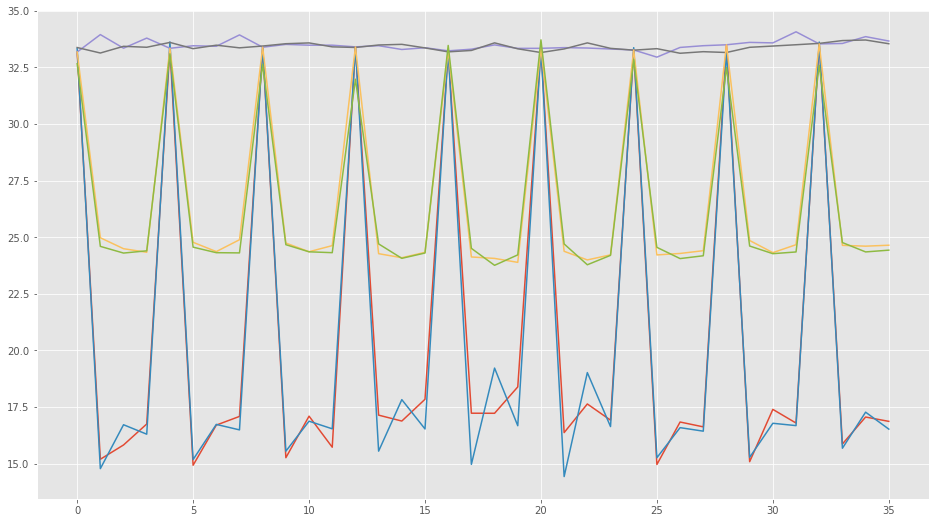

In [20]:
# line plot of observed vs predicted
plt.plot(test[n_steps:,0])
plt.plot(predictions1)
plt.plot(test[n_steps:,1])
plt.plot(predictions2)
plt.plot(test[n_steps:,2])
plt.plot(predictions3)
#pyplot.show()

In [22]:
rmse = math.sqrt(mean_squared_error(test[n_steps:,0], predictions1))
print('Test RMSE T_degC: %.3f' % rmse)
rmse = math.sqrt(mean_squared_error(test[n_steps:,1], predictions2))
print('Test RMSE Salnty: %.3f' % rmse)
rmse = math.sqrt(mean_squared_error(test[n_steps:,2], predictions3))
print('Test RMSE STheta: %.3f' % rmse)

Test RMSE T_degC: 0.855
Test RMSE Salnty: 0.253
Test RMSE STheta: 0.444


In [24]:
lowp=low
yearsp=3
for i in range(yearsp*4):
    lowp=lowp.append(pd.Series(), ignore_index=True)
rangee=lowp.T_degC.isnull().sum()
for xxxx in range(rangee):
    # define input sequence
    stop=lowp.T_degC.isnull().idxmax()
    x_input = lowp[['T_degC','Salnty','STheta']].loc[stop-n_steps:stop-1].values
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    lowp.T_degC[stop]=yhat[0,0]
    lowp.Salnty[stop]=yhat[0,1]
    lowp.STheta[stop]=yhat[0,2]
    print("low data:",xxxx+1,"/",rangee)


low data: 1 / 12
low data: 2 / 12
low data: 3 / 12
low data: 4 / 12
low data: 5 / 12
low data: 6 / 12
low data: 7 / 12
low data: 8 / 12
low data: 9 / 12
low data: 10 / 12
low data: 11 / 12
low data: 12 / 12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


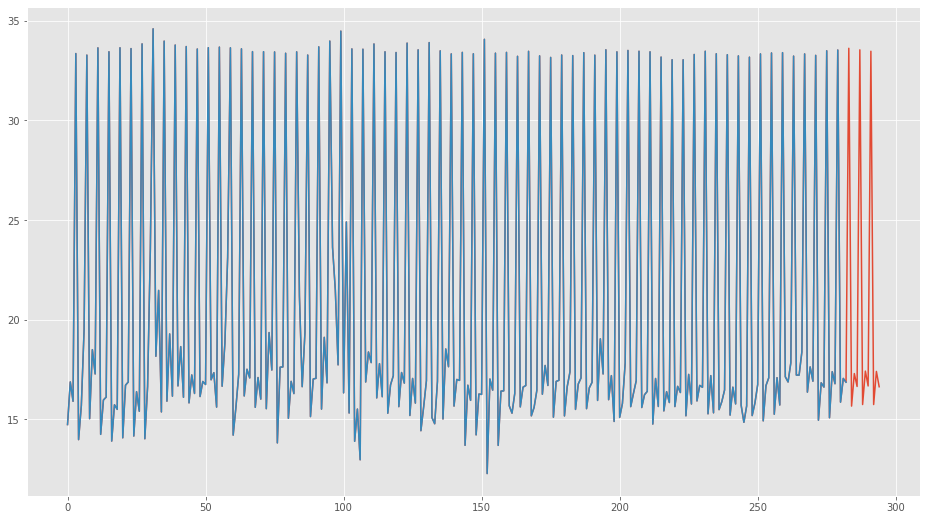

In [25]:
plt.plot(lowp.T_degC)
plt.plot(low.T_degC)

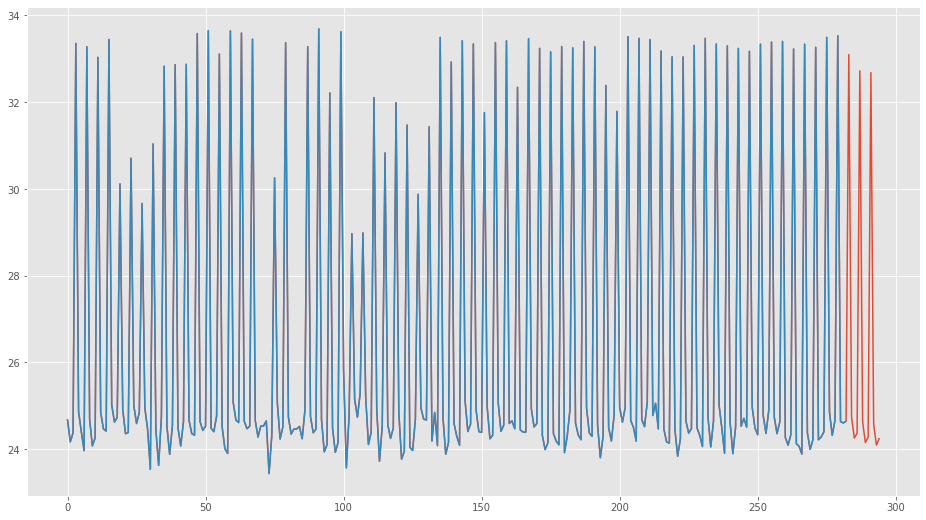

In [26]:
plt.plot(lowp.STheta)
plt.plot(low.STheta)

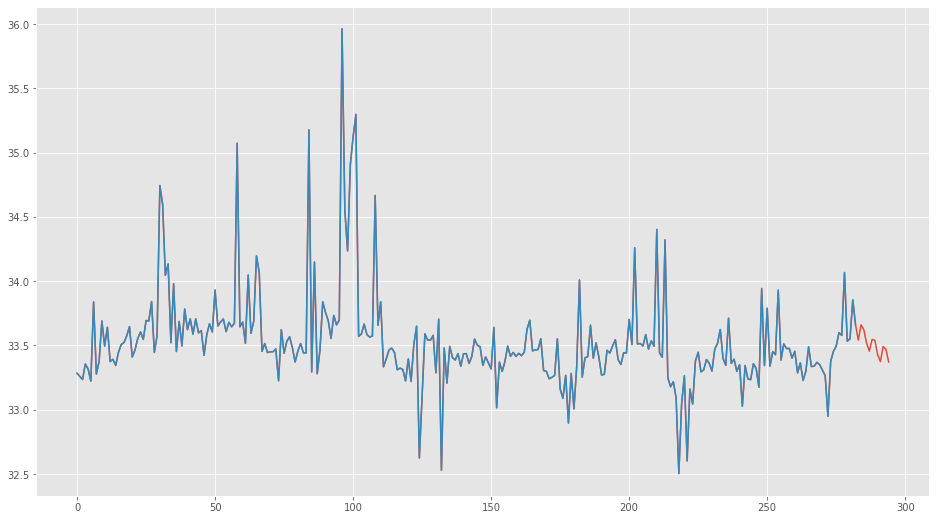

In [27]:
plt.plot(lowp.Salnty)
plt.plot(low.Salnty)

In [30]:
midp=mid
yearsp=3
for i in range(yearsp*4):
    midp=midp.append(pd.Series(), ignore_index=True)
rangee=midp.T_degC.isnull().sum()
for xxxx in range(rangee):
    # define input sequence
    stop=midp.T_degC.isnull().idxmax()
    x_input = midp[['T_degC','Salnty','STheta']].loc[stop-n_steps:stop-1].values
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    midp.T_degC[stop]=yhat[0,0]
    midp.Salnty[stop]=yhat[0,1]
    midp.STheta[stop]=yhat[0,2]
    print("mid data:",xxxx+1,"/",rangee)


mid data: 1 / 12
mid data: 2 / 12
mid data: 3 / 12
mid data: 4 / 12
mid data: 5 / 12
mid data: 6 / 12
mid data: 7 / 12
mid data: 8 / 12
mid data: 9 / 12
mid data: 10 / 12
mid data: 11 / 12
mid data: 12 / 12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


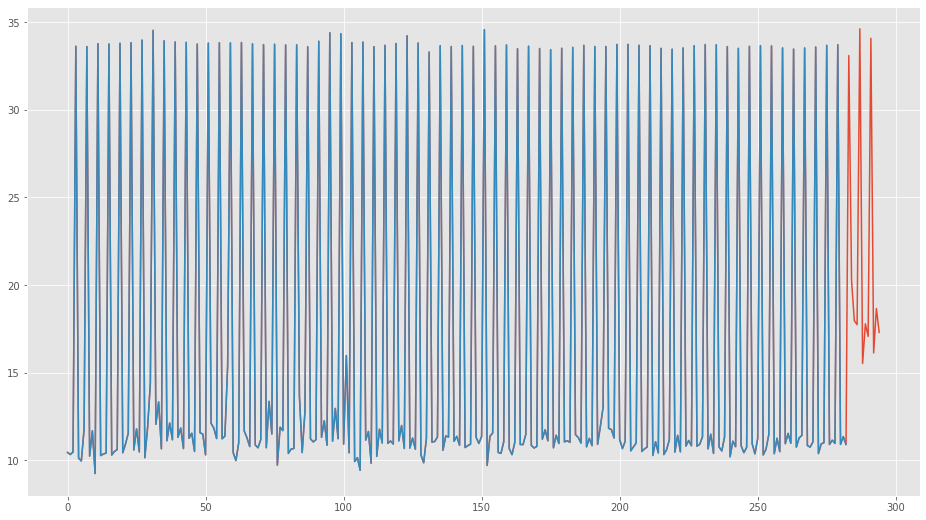

In [31]:
plt.plot(midp.T_degC)
plt.plot(mid.T_degC)

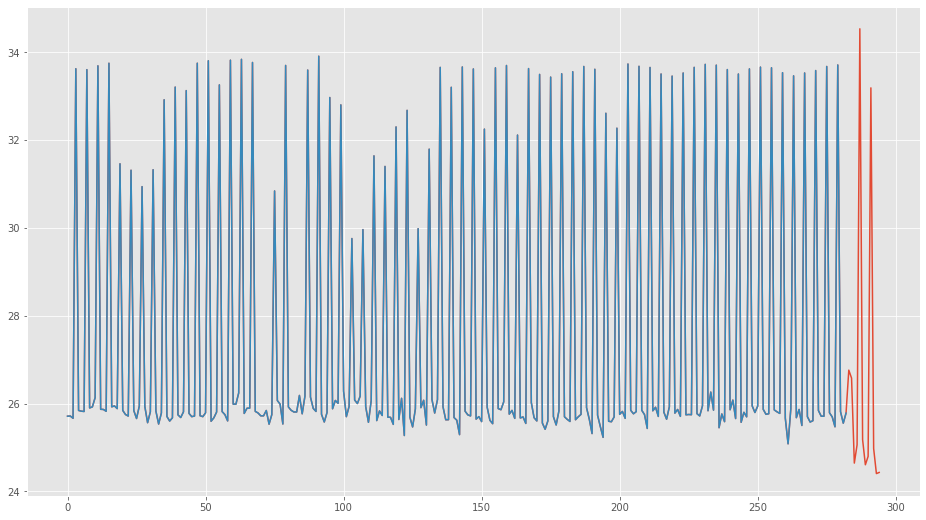

In [32]:
plt.plot(midp.STheta)
plt.plot(mid.STheta)

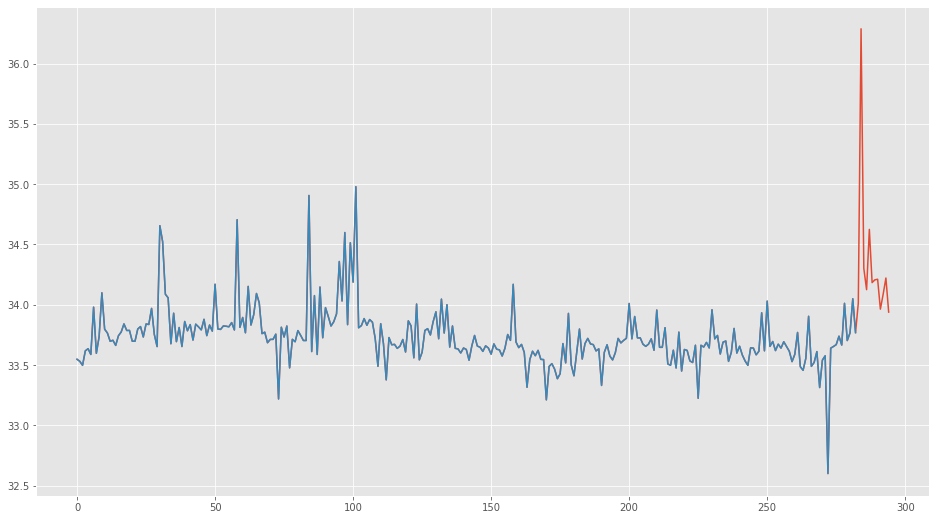

In [33]:
plt.plot(midp.Salnty)
plt.plot(mid.Salnty)

In [34]:
highp=high
yearsp=3
for i in range(yearsp*4):
    highp=highp.append(pd.Series(), ignore_index=True)
rangee=highp.T_degC.isnull().sum()
for xxxx in range(rangee):
    # define input sequence
    stop=highp.T_degC.isnull().idxmax()
    x_input = highp[['T_degC','Salnty','STheta']].loc[stop-n_steps:stop-1].values
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    highp.T_degC[stop]=yhat[0,0]
    highp.Salnty[stop]=yhat[0,1]
    highp.STheta[stop]=yhat[0,2]
    print("low data:",xxxx+1,"/",rangee)

low data: 1 / 12
low data: 2 / 12
low data: 3 / 12
low data: 4 / 12
low data: 5 / 12
low data: 6 / 12
low data: 7 / 12
low data: 8 / 12
low data: 9 / 12
low data: 10 / 12
low data: 11 / 12
low data: 12 / 12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


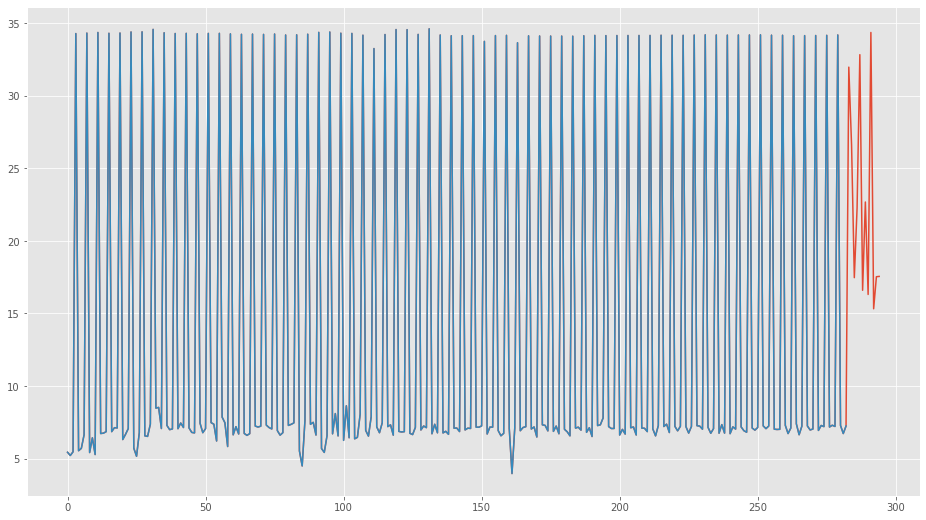

In [35]:
plt.plot(highp.T_degC)
plt.plot(high.T_degC)

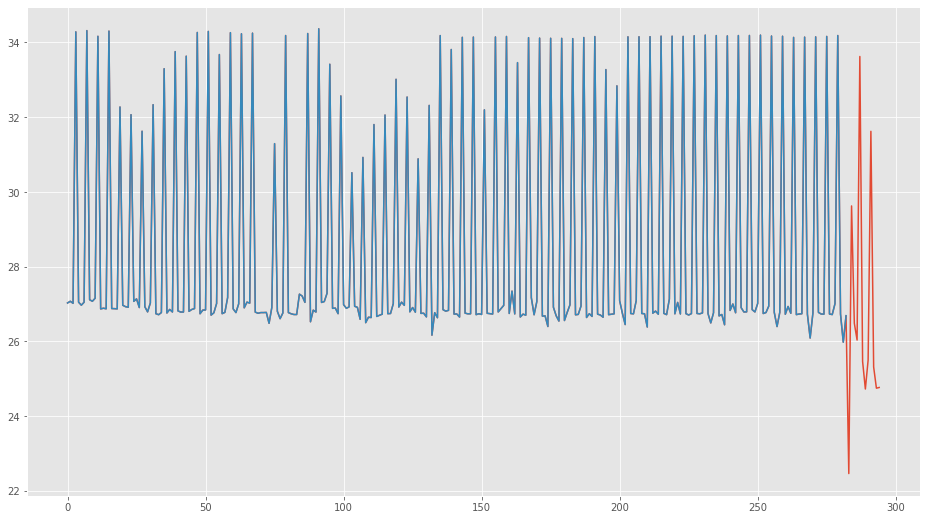

In [36]:
plt.plot(highp.STheta)
plt.plot(high.STheta)

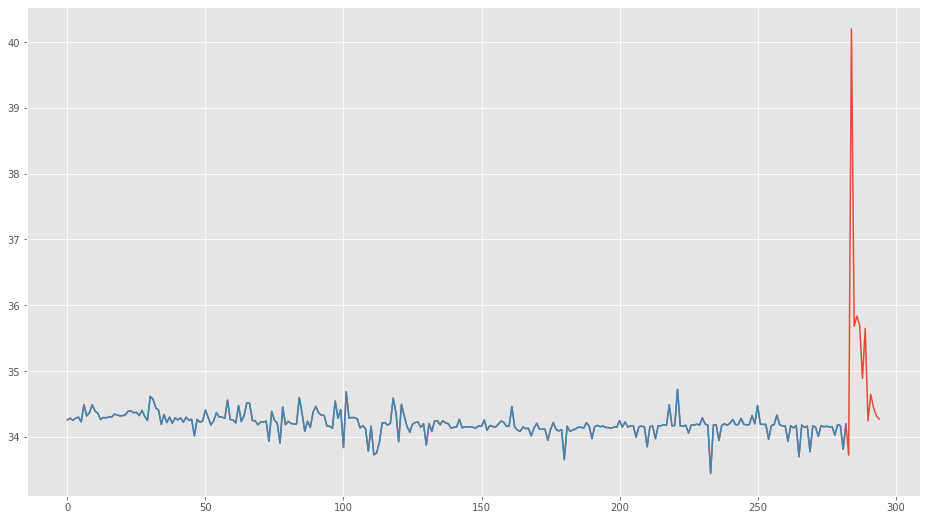

In [37]:
plt.plot(highp.Salnty)
plt.plot(high.Salnty)